# Training on whole dataset 

In [ ]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import FunctionTransformer
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.neural_network import MLPClassifier
from catboost import CatBoostClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import cross_validate, train_test_split, cross_val_score, StratifiedKFold
from sklearn.metrics import roc_auc_score, roc_curve, precision_recall_curve, auc, confusion_matrix, classification_report, RocCurveDisplay
from sklearn.pipeline import Pipeline
from sklearn.utils import class_weight
from matplotlib import pyplot as plt
import optuna
from optuna.pruners import HyperbandPruner
import warnings
import dill
from datetime import datetime
import itertools
import lightgbm as lgb

warnings.filterwarnings('ignore')
optuna.logging.set_verbosity(optuna.logging.WARNING)

In [ ]:
df_final = pd.read_csv('data/df_final')

In [72]:
df_final.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3000000 entries, 0 to 2999999
Columns: 361 entries, id to flag
dtypes: float64(10), int32(1), int64(1), int8(349)
memory usage: 1.2 GB


In [73]:
df_final.flag.value_counts(normalize=True)

flag
0    0.964519
1    0.035481
Name: proportion, dtype: float64

There is obvious imbalance of classes (0.964519 to 0.035481).

For this reason, to solve the problem, we will use in the future tuning the class_weights hyperparameter

In [74]:
# Initializing features and target variable. 
X = df_final.drop(['flag'], axis=1)
y = df_final.flag

# train_test_split 
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, test_size=0.2, random_state=12)

## Обучения-модели на всём датафрейме.

In [75]:

models = [LogisticRegression(random_state=12),
          RandomForestClassifier(random_state=12),
          CatBoostClassifier(random_seed=12)
         ]

In [76]:
from datetime import datetime
for model in models:
    start= datetime.now()
    print('Start time ', start)
    score = cross_val_score(model, X_train.drop(columns=['id']), y_train, scoring='roc_auc', cv=3, n_jobs=-1)
    print('Duration ', datetime.now()-start)
    print('Модель: ', model)
    print('Roc-auc:', round(score.mean(),4))

Текущая время  2024-07-06 11:19:11.915742


 время  0:03:54.616779
Модель:  LogisticRegression(random_state=12)
Roc-auc: 0.7402

Текущая время  2024-07-06 11:23:28.233855
 время  0:53:23.351923
Модель:  RandomForestClassifier(random_state=12)
Roc-auc: 0.7101

Текущая время  2024-07-06 11:38:59.586332
Learning rate set to 0.240488
0:	learn: 0.4010948	total: 278ms	remaining: 4m 37s
1:	learn: 0.2684846	total: 536ms	remaining: 4m 27s
2:	learn: 0.2086466	total: 804ms	remaining: 4m 27s
3:	learn: 0.1774475	total: 996ms	remaining: 4m 8s
4:	learn: 0.1627678	total: 1.23s	remaining: 4m 4s
5:	learn: 0.1542831	total: 1.53s	remaining: 4m 13s
6:	learn: 0.1493318	total: 1.82s	remaining: 4m 17s
7:	learn: 0.1464778	total: 2.06s	remaining: 4m 15s
8:	learn: 0.1447649	total: 2.32s	remaining: 4m 15s
9:	learn: 0.1437130	total: 2.54s	remaining: 4m 11s
10:	learn: 0.1429248	total: 2.88s	remaining: 4m 19s
11:	learn: 0.1424163	total: 3.14s	remaining: 4m 18s
12:	learn: 0.1420212	total: 3.39s	remaining: 4m 17s
13:	learn: 0.1417108	total: 3.67s	remaining: 4m 

In [77]:
# Cross-validation metric values on different data volumes.
# The metric decreases when using all the data compared to using 1/12 of the data.
# Let's improve the CatBoostClassifier model.

## CatBoostClassifier

In [78]:
model = CatBoostClassifier(random_seed=12)

In [79]:
def filter_data(df):
    df_temp = df.copy()
    columns_to_drop = ['id']

    return df_temp.drop(columns_to_drop, axis=1)

In [80]:
def new_features(df):
    df_temp = df.copy()
    df_temp['is_zero_loans_risk'] = df_temp[['is_zero_loans5', 'is_zero_loans530', 'is_zero_loans3060', 'is_zero_loans6090', 'is_zero_loans90']].lt(0.6).sum(axis=1)
    df_temp['is_zero_loans_points'] = df_temp['is_zero_loans5']*1 + df_temp['is_zero_loans530']*1.5 + df_temp['is_zero_loans3060']*2 + df_temp['is_zero_loans6090']*2.5 + df_temp['is_zero_loans90']*3
    
    return df_temp

In [81]:
# Pipeline preprocessor for new features
preprocessor = Pipeline(steps=[
    ('filter', FunctionTransformer(filter_data)),
    ('new_features', FunctionTransformer(new_features))])

In [82]:
def objective(trial):    
    
    # List of hyperparameters 
    params = {
        "objective": trial.suggest_categorical("objective", ["CrossEntropy"]),
        "learning_rate": trial.suggest_float("learning_rate", 0.005, 0.5),
        "min_data_in_leaf": trial.suggest_int("min_data_in_leaf", 35, 40),
        "depth": trial.suggest_int("depth", 8, 10),
        }
                        
    
    model.set_params(**params)
    
    
    # Pipeline 
    pipeline = Pipeline(steps=[
        ('preprocessor', preprocessor),
        ('classifier', model)
    ])
    
    # Cross-validation 
    start= datetime.now()
    print('Текущая время ', start)
    score = cross_val_score(pipeline, X_train, y_train, cv=3, n_jobs=-1, scoring= 'roc_auc').mean()
    print(' время ', datetime.now()-start)
    return score

study = optuna.create_study(direction="maximize", pruner=HyperbandPruner)
study.optimize(objective, n_trials=100)

print('Лучшие гиперпараметры:', study.best_trial.params)
print('Лучшее значение roc-auc:', study.best_trial.value)

Текущая время  2024-07-06 15:13:12.196893
0:	learn: 0.2356309	total: 266ms	remaining: 4m 25s
1:	learn: 0.1629963	total: 534ms	remaining: 4m 26s
2:	learn: 0.1476735	total: 866ms	remaining: 4m 47s
3:	learn: 0.1435370	total: 1.26s	remaining: 5m 12s
4:	learn: 0.1418055	total: 1.6s	remaining: 5m 17s
5:	learn: 0.1407978	total: 1.95s	remaining: 5m 23s
6:	learn: 0.1401383	total: 2.33s	remaining: 5m 31s
7:	learn: 0.1397154	total: 2.78s	remaining: 5m 45s
8:	learn: 0.1394081	total: 3.15s	remaining: 5m 46s
9:	learn: 0.1391658	total: 3.47s	remaining: 5m 43s
10:	learn: 0.1388147	total: 3.9s	remaining: 5m 50s
11:	learn: 0.1386121	total: 4.24s	remaining: 5m 48s
12:	learn: 0.1384081	total: 4.64s	remaining: 5m 52s
13:	learn: 0.1380688	total: 5.06s	remaining: 5m 56s
14:	learn: 0.1378999	total: 5.45s	remaining: 5m 57s
15:	learn: 0.1376858	total: 5.84s	remaining: 5m 59s
16:	learn: 0.1375612	total: 6.19s	remaining: 5m 58s
17:	learn: 0.1373134	total: 6.6s	remaining: 5m 59s
18:	learn: 0.1371915	total: 6.94s	r

In [83]:
# optimal hyperameters.
catboost_best = CatBoostClassifier(max_depth=9, objective='CrossEntropy', min_data_in_leaf=37, 
                                   learning_rate=0.06553798310275494, random_seed=12)

In [84]:
catboost_pipeline = Pipeline(steps=[
        ('preprocessor', preprocessor),
        ('classifier', catboost_best)
    ])

In [85]:
from datetime import datetime
start= datetime.now()
print('Текущая время ', start)
catboost_pipeline.fit(X_train, y_train)
print(' время ', datetime.now()-start)

Текущая время  2024-07-06 15:39:41.177755
0:	learn: 0.5971989	total: 188ms	remaining: 3m 7s
1:	learn: 0.5168465	total: 357ms	remaining: 2m 58s
2:	learn: 0.4522163	total: 489ms	remaining: 2m 42s
3:	learn: 0.3997978	total: 629ms	remaining: 2m 36s
4:	learn: 0.3560389	total: 766ms	remaining: 2m 32s
5:	learn: 0.3208055	total: 890ms	remaining: 2m 27s
6:	learn: 0.2913407	total: 1.03s	remaining: 2m 25s
7:	learn: 0.2679652	total: 1.16s	remaining: 2m 23s
8:	learn: 0.2480782	total: 1.3s	remaining: 2m 23s
9:	learn: 0.2316891	total: 1.44s	remaining: 2m 22s
10:	learn: 0.2184137	total: 1.58s	remaining: 2m 21s
11:	learn: 0.2070920	total: 1.73s	remaining: 2m 22s
12:	learn: 0.1976725	total: 1.9s	remaining: 2m 23s
13:	learn: 0.1890377	total: 2.05s	remaining: 2m 24s
14:	learn: 0.1819714	total: 2.22s	remaining: 2m 25s
15:	learn: 0.1763848	total: 2.38s	remaining: 2m 26s
16:	learn: 0.1717090	total: 2.52s	remaining: 2m 26s
17:	learn: 0.1673050	total: 2.71s	remaining: 2m 27s
18:	learn: 0.1639539	total: 2.88s	r

In [86]:
# prediction 
catboost_pred_test = catboost_pipeline.predict(X_test)

In [87]:
catboost_probs = catboost_pipeline.predict_proba(X_test)[:, 1]

In [88]:
print('Итоговая CatBoostClassifier')
print('Значение roc_auc на тестовой выборке: ', round(roc_auc_score(y_test, catboost_probs),4)) 

Итоговая CatBoostClassifier
Значение roc_auc на тестовой выборке:  0.7621


In [89]:
catboost_feature_names = catboost_pipeline[1].feature_names_

catboost_importances = pd.Series(catboost_pipeline[1].feature_importances_, index=catboost_feature_names).sort_values(ascending=True)

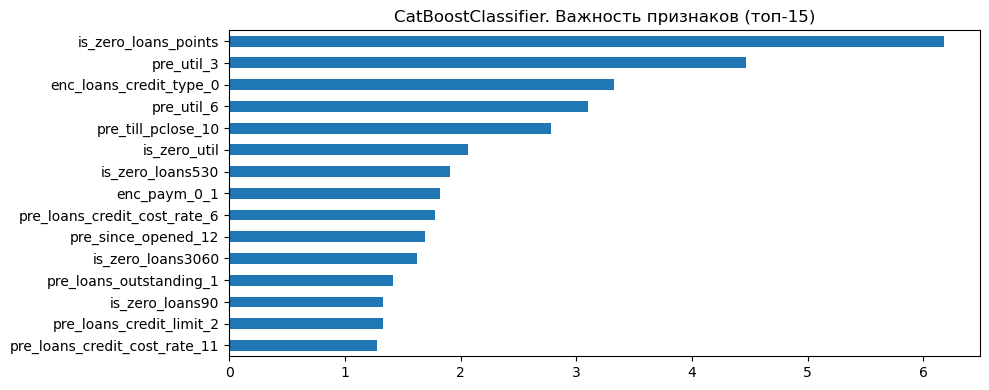

In [90]:
# Important features 

ax = catboost_importances[-15:].plot.barh(figsize=(10,4))
ax.set_title("CatBoostClassifier. Важность признаков (топ-15)")
ax.figure.tight_layout()

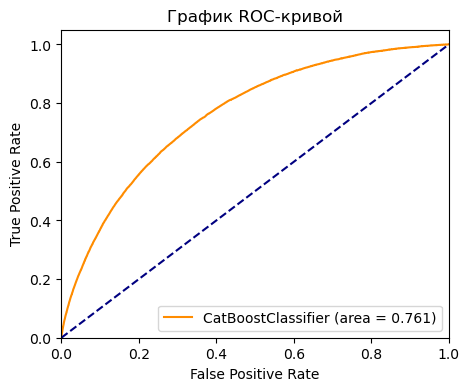

In [91]:
# roc-кривой.
fpr_cat, tpr_cat, treshold_cat = roc_curve(y_test, catboost_probs)
roc_auc_cat = auc(fpr_cat, tpr_cat)

plt.figure(figsize=(5, 4))
plt.plot(fpr_cat, tpr_cat, color='darkorange',
         label='CatBoostClassifier (area = %0.3f)' % roc_auc_cat)
plt.plot([0, 1], [0, 1], color='navy', linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('График ROC-кривой')
plt.legend(loc="lower right")
plt.show()

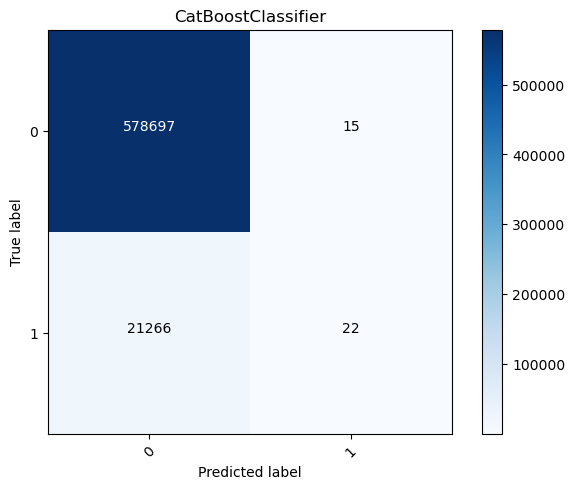

In [92]:
# before putting the model into production, the decision threshold will need to be adjusted downwards
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
 
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)
 
    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")
 
    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
plot_confusion_matrix(confusion_matrix(y_test, catboost_pred_test), classes=['0','1'], title='CatBoostClassifier')

In [93]:
print(classification_report(y_test, catboost_pred_test))

              precision    recall  f1-score   support

           0       0.96      1.00      0.98    578712
           1       0.59      0.00      0.00     21288

    accuracy                           0.96    600000
   macro avg       0.78      0.50      0.49    600000
weighted avg       0.95      0.96      0.95    600000



## Best model in the pipeline.



**Result in the testing set - 0.7621**

In [94]:
# Prediction in the testing dataset.
test_pred = pd.DataFrame(data = {
    'id': X_test['id'],
    'predictions': catboost_pred_test
})

test_pred.head()

id  predictions
1334549  1334549            0
2385553  2385553            0
2242330  2242330            0
2182598  2182598            0
2318320  2318320            0

In [95]:
test_pred.to_csv('test_predictions.csv')

#### Saving the pipeline

In [96]:
def filter_data(df):
    df_temp = df.copy()
    columns_to_drop = ['id']

    return df_temp.drop(columns_to_drop, axis=1)

In [97]:
def new_features(df):
    df_temp = df.copy()
    df_temp['is_zero_loans_risk'] = df_temp[['is_zero_loans5', 'is_zero_loans530', 'is_zero_loans3060', 'is_zero_loans6090', 'is_zero_loans90']].lt(0.6).sum(axis=1)
    df_temp['is_zero_loans_points'] = df_temp['is_zero_loans5']*1 + df_temp['is_zero_loans530']*1.5 + df_temp['is_zero_loans3060']*2 + df_temp['is_zero_loans6090']*2.5 + df_temp['is_zero_loans90']*3
    
    return df_temp

In [98]:
preprocessor = Pipeline(steps=[
    ('filter', FunctionTransformer(filter_data)),
    ('new_features', FunctionTransformer(new_features))])

In [99]:
catboost_best = CatBoostClassifier(max_depth=9, objective='CrossEntropy', min_data_in_leaf=37, 
                                   learning_rate=0.06553798310275494, random_seed=73)

In [100]:
catboost_pipeline = Pipeline(steps=[
        ('preprocessor', preprocessor),
        ('classifier', catboost_best)
    ])

In [101]:
start= datetime.now()
print('Текущая время ', start)
catboost_pipeline.fit(X,y)
print(' время ', datetime.now()-start)

Текущая время  2024-07-06 16:28:06.464611
0:	learn: 0.5969688	total: 193ms	remaining: 3m 13s
1:	learn: 0.5182569	total: 343ms	remaining: 2m 50s
2:	learn: 0.4538180	total: 513ms	remaining: 2m 50s
3:	learn: 0.4012854	total: 668ms	remaining: 2m 46s
4:	learn: 0.3579834	total: 807ms	remaining: 2m 40s
5:	learn: 0.3213688	total: 976ms	remaining: 2m 41s
6:	learn: 0.2919710	total: 1.17s	remaining: 2m 46s
7:	learn: 0.2675425	total: 1.36s	remaining: 2m 49s
8:	learn: 0.2482633	total: 1.49s	remaining: 2m 44s
9:	learn: 0.2318259	total: 1.65s	remaining: 2m 42s
10:	learn: 0.2178955	total: 1.84s	remaining: 2m 45s
11:	learn: 0.2068385	total: 1.99s	remaining: 2m 43s
12:	learn: 0.1964337	total: 2.23s	remaining: 2m 49s
13:	learn: 0.1883397	total: 2.44s	remaining: 2m 52s
14:	learn: 0.1819158	total: 2.62s	remaining: 2m 51s
15:	learn: 0.1763118	total: 2.8s	remaining: 2m 52s
16:	learn: 0.1714253	total: 2.99s	remaining: 2m 53s
17:	learn: 0.1670946	total: 3.21s	remaining: 2m 55s
18:	learn: 0.1636304	total: 3.42s

In [102]:
# Saving the pipeline.

with open(path+'risk_predictor.pkl', 'wb') as file:
    dill.dump({
        'model': catboost_pipeline,
        'metadata': {
            'name': 'Credit Risk Predictor',
            'author': 'Quranboyev Behruz',
            'version': '1',
            'date': '6.07.2024',
        }
    }, file)

In [103]:
# Results
# LogisticRegression        Roc-auc: 0.7402
# RandomForestClassifier    Roc-auc: 0.7101
# CatBoostClassifier        Roc-auc: 0.7621     

# Training with LightGBM model

In [104]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
 
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)
 
    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")
 
    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

In [105]:
X = df_final.drop(["flag",'id'], axis=1)
y = df_final["flag"]
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=12, stratify=y
)


print(X_train.shape, X_test.shape)

(2400000, 359) (600000, 359)


In [106]:
train_data = lgb.Dataset(X_train, label=y_train)

validation_data = lgb.Dataset(X_test, label=y_test, reference=train_data)

## Training 

Let's calculate the weights and mark the vector of class weights for each object:

In [107]:
param = {'num_leaves': 31, 'objective': 'binary', 'metric': 'auc'}

class_weights = class_weight.compute_class_weight(class_weight='balanced', 
                                                  classes=np.unique(y_train), y=y_train)
# Taking into account weights
weights = np.zeros_like(y_train).astype(np.float32)
weights[y_train == 0] = class_weights[0]
weights[y_train == 1] = class_weights[1]
train_data.set_weight(weights)

num_round = 1000
start = datetime.now()
print('Начало обучения ',start)
bst = lgb.train(param, train_data, num_round, valid_sets=[validation_data])
print('Время обучения ',datetime.now()-start)

Начало обучения  2024-07-06 20:52:51.476855
[LightGBM] [Info] Number of positive: 85154, number of negative: 2314846
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.839492 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 6816
[LightGBM] [Info] Number of data points in the train set: 2400000, number of used features: 358
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=-0.000000
[LightGBM] [Info] Start training from score -0.000000
Время обучения  0:03:15.886249


In [108]:
y_pred = np.round(bst.predict(X_test))

In [109]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.98      0.71      0.83    578712
           1       0.08      0.66      0.14     21288

    accuracy                           0.71    600000
   macro avg       0.53      0.69      0.48    600000
weighted avg       0.95      0.71      0.80    600000



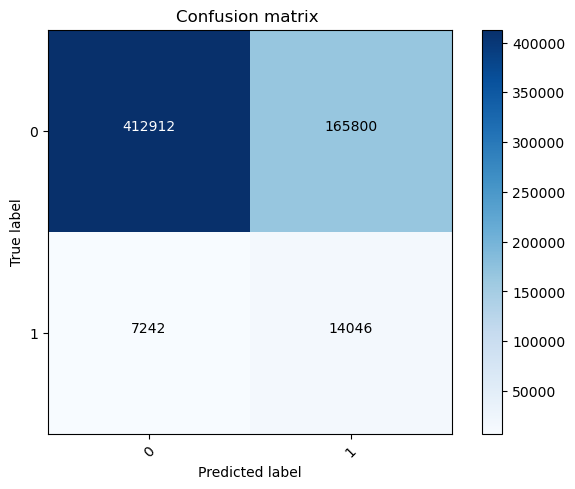

In [110]:
plot_confusion_matrix(confusion_matrix(y_test, y_pred), classes=['0','1'],
                      title='Confusion matrix ')


Text(0.5, 1.0, 'LightGBM | With weights')

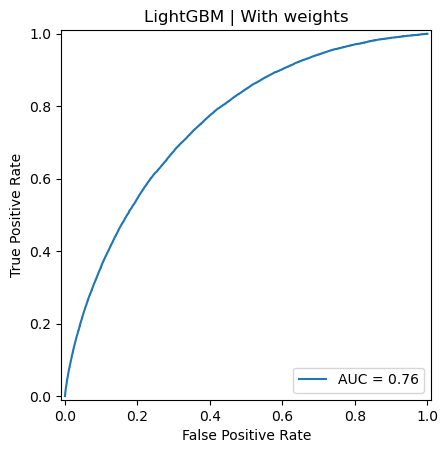

In [111]:
# Calculate the value of the AUC metric and build an ROC curve

y_pred_proba = bst.predict(X_test)
fpr, tpr, _ = roc_curve(y_test, y_pred_proba)
roc_auc = auc(fpr, tpr)


RocCurveDisplay(fpr=fpr, tpr=tpr, roc_auc=roc_auc).plot()
plt.title('LightGBM ')


# сохранить модель

In [112]:
bst.save_model(path+'best_LightGBM.txt', num_iteration=bst.best_iteration)

#  Results

Visualise the results:

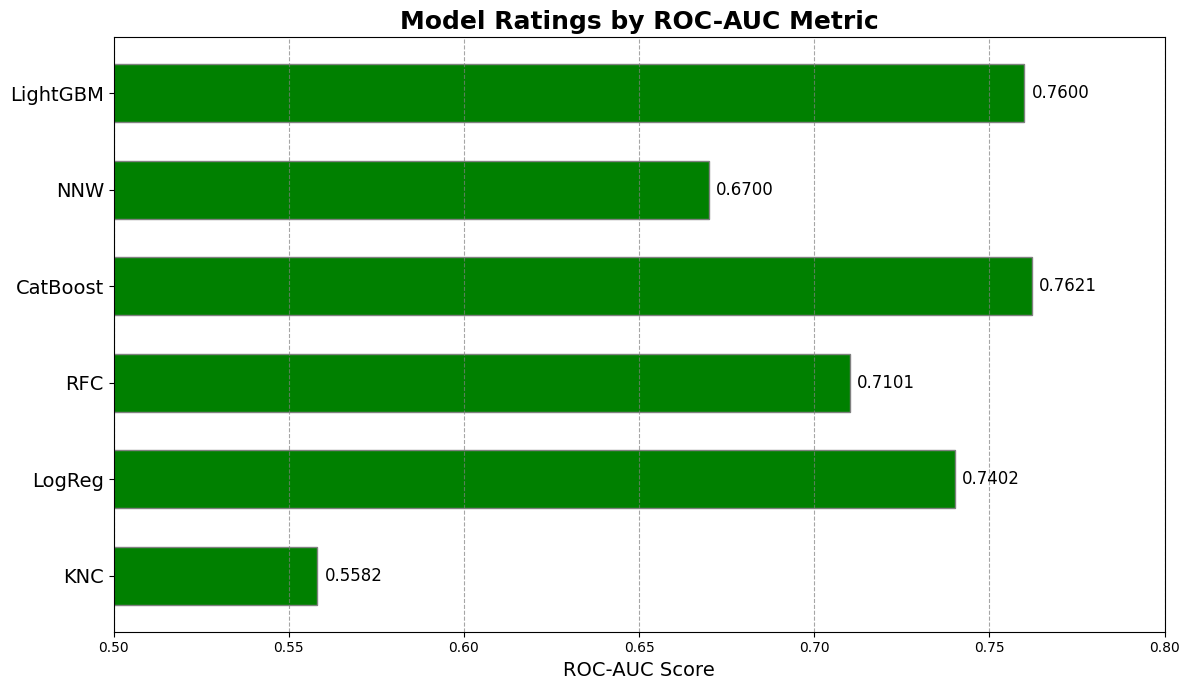

In [8]:
labels = ['KNC', 'LogReg', 'RFC', 'CatBoost', 'NNW', 'LightGBM']
scores = [0.5582, 0.7402, 0.7101, 0.7621, 0.67, 0.76]

fig, ax = plt.subplots(figsize=(12, 7))
y_positions = np.arange(len(labels))
bar_height = 0.6

bars = ax.barh(y_positions, scores, height=bar_height, color='green', edgecolor='grey')

ax.set_title('Model Ratings by ROC-AUC Metric', fontsize=18, fontweight='bold')
ax.set_yticks(y_positions)
ax.set_yticklabels(labels, fontsize=14)
ax.set_xlim(0.5, 0.8)
ax.set_xlabel('ROC-AUC Score', fontsize=14)

for bar in bars:
    ax.annotate(f'{bar.get_width():.4f}', 
                xy=(bar.get_width(), bar.get_y() + bar.get_height() / 2),
                xytext=(5, 0), textcoords='offset points',
                ha='left', va='center', fontsize=12, color='black')

ax.xaxis.grid(True, linestyle='--', which='major', color='grey', alpha=0.7)
fig.tight_layout()
plt.show()

# Conclusion

As a result the the bodels trained with CatBoost and LightGMB got accuracy по метрика Roc-auc higher than 0.75